In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Define paths to dataset directories
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size for resizing
IMG_SIZE = 32  # Resize images to 32x32

# Helper function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

In [4]:
train_images, train_labels = images, labels

##1. Class Distribution <br>
We'll first check the number of images in each traffic sign class. This will help us identify any class imbalances, which is a common problem in datasets like GTSRB.

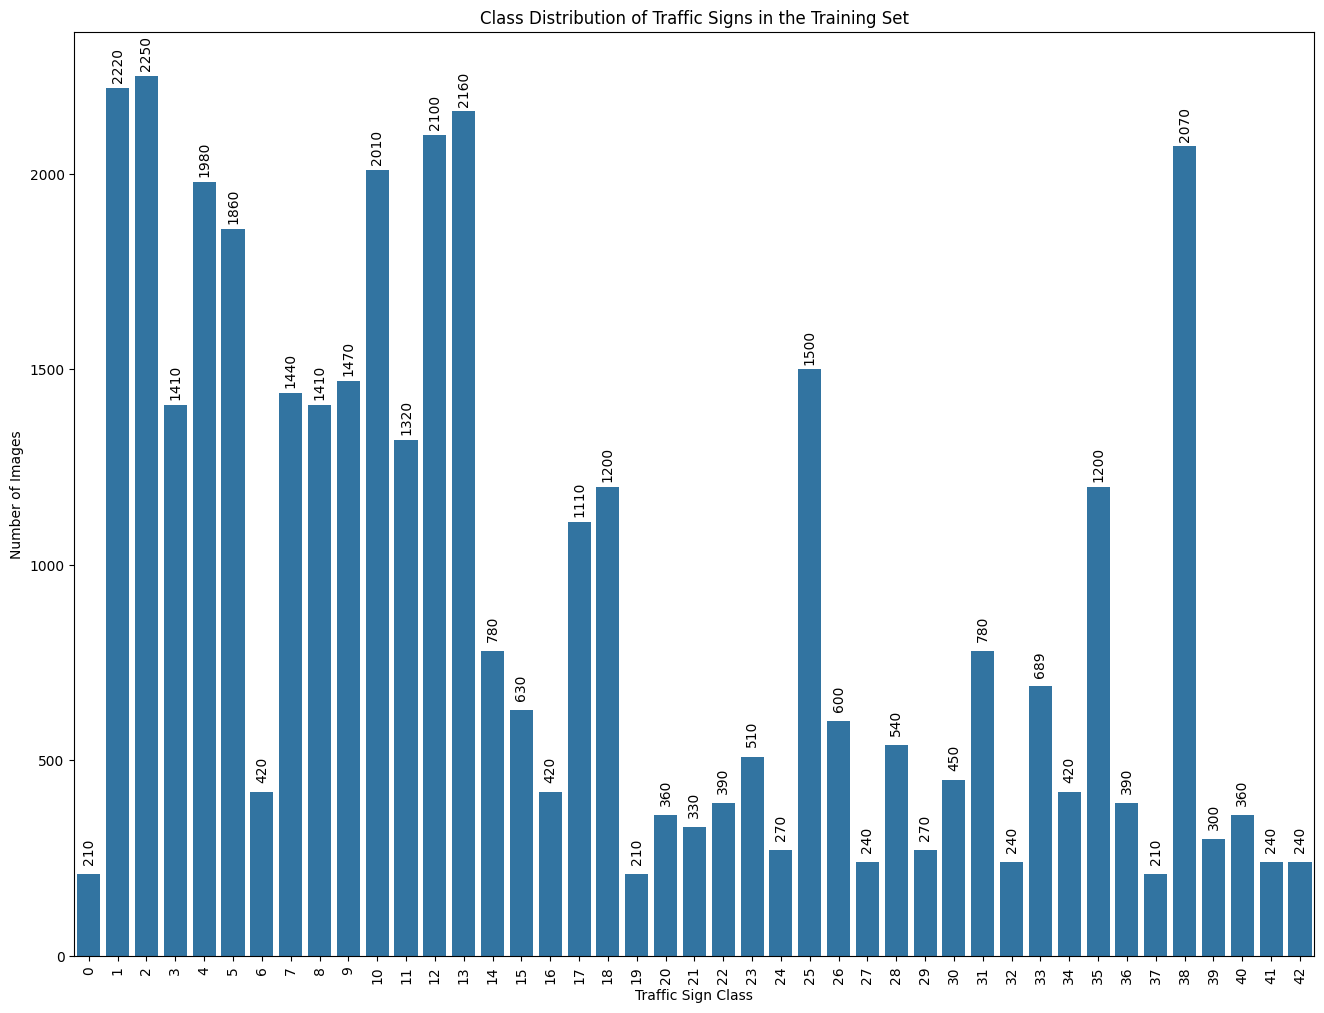

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Convert labels to categorical format for better visualization
def plot_class_distribution(train_labels):
    # Count the number of samples per class
    class_counts = Counter(train_labels)

    # Plot class distribution
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))

    # Add the counts of each class on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',   # Text to display (image count)
                    (p.get_x() + p.get_width() / 2., p.get_height()+40),  # Coordinates of the text
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', rotation=90)  # Positioning

    plt.title("Class Distribution of Traffic Signs in the Training Set", fontsize=10)
    plt.xlabel("Traffic Sign Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.show()

plot_class_distribution(train_labels)

##Image Normalization <br>
Image normalization (scaling pixel values to the range [0, 1] or applying mean subtraction) helps the model converge more quickly and perform better.

In [ ]:
train_images = train_images.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

##2. Visualizing Sample Images <br>
Next, let’s visualize some random images from the dataset to ensure that the images were loaded correctly and to get a feel for the data.

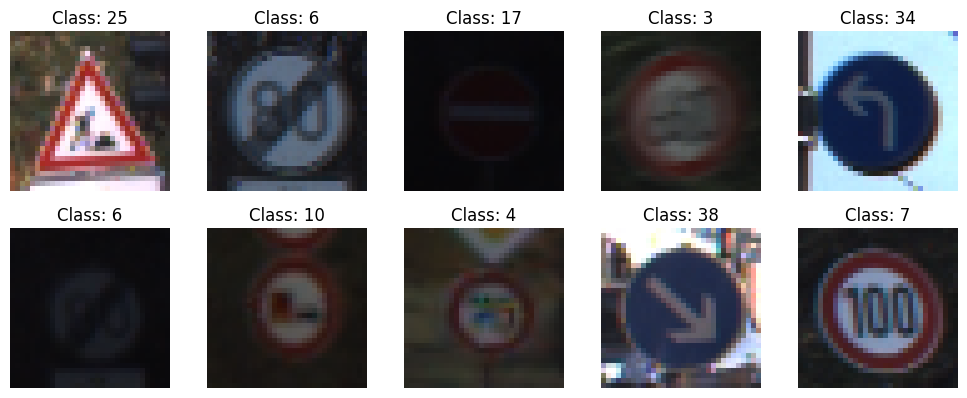

In [ ]:
def visualize_random_images(train_images, train_labels, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        random_idx = np.random.randint(0, len(train_images))  # Pick a random image index
        plt.imshow(cv2.cvtColor(train_images[random_idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.title(f'Class: {train_labels[random_idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_random_images(train_images, train_labels)

##3. Checking Image Shape Consistency <br>
We want to ensure that all images in the dataset have been resized to the same dimensions (32x32 pixels as specified). This is crucial for model input consistency.

In [ ]:
def check_image_shape(train_images):
    print(f"Expected image shape: (32, 32, 3)")
    shapes = [img.shape for img in train_images]
    unique_shapes = set(shapes)
    print(f"Unique image shapes in dataset: {unique_shapes}")

check_image_shape(train_images)

Expected image shape: (32, 32, 3)
Unique image shapes in dataset: {(32, 32, 3)}


##4. Pixel Intensity Distribution <br>
The images have been normalized (as expected in most deep learning applications), so it’s useful to check the distribution of pixel intensities to ensure that the normalization was applied correctly.

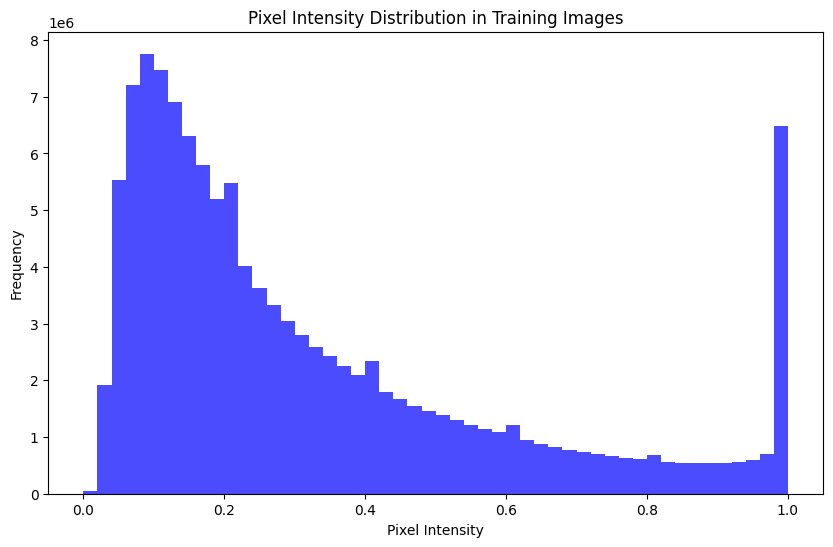

In [ ]:
def plot_pixel_intensity_distribution(train_images):
    pixel_values = train_images.ravel()  # Flatten the pixel values into a 1D array
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Intensity Distribution in Training Images')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_intensity_distribution(train_images)

##5. Class Balance in Training and Validation Sets <br>
When we split the dataset into training and validation sets, it's important to ensure that the class distribution is maintained in both subsets. We can plot the distribution of classes in both sets to verify this.

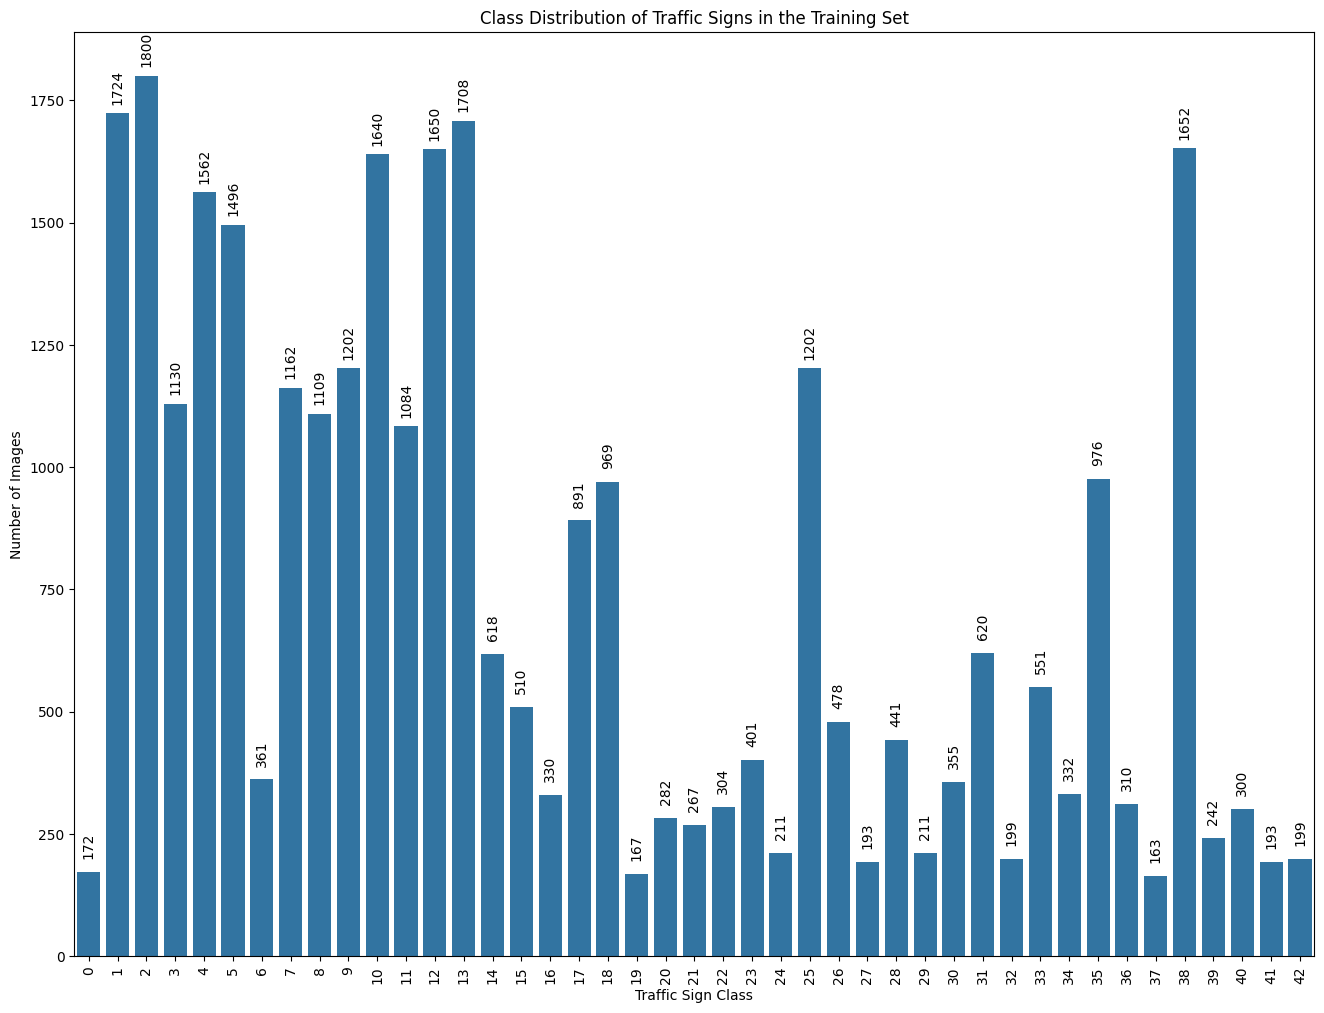

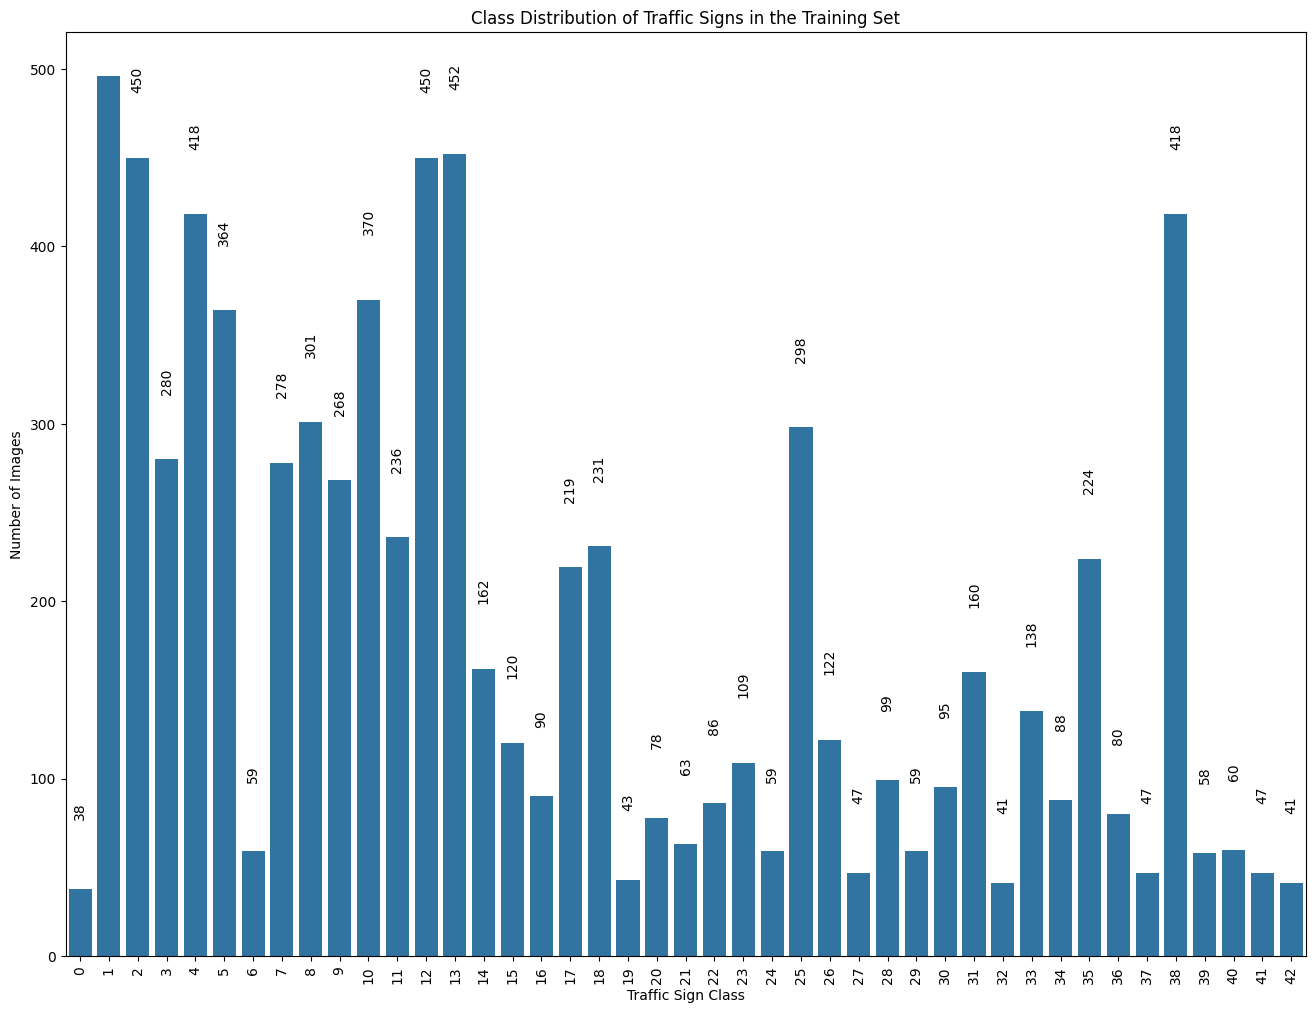

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Visualize class distribution in training set
plot_class_distribution(y_train)

# Visualize class distribution in validation set
plot_class_distribution(y_val)

In [ ]:
print(len(X_train))
print(len(X_val))

31367
7842


##6. Checking for Missing or Corrupted Data <br>
Finally, it’s important to check if there are any missing or corrupted images in the dataset (e.g., images with NaN values).

In [ ]:
def check_for_missing_data(X_train):
    if np.any(np.isnan(X_train)):
        print("Warning: There are missing or NaN values in the images!")
    else:
        print("No missing or NaN values found in the dataset.")

check_for_missing_data(X_train)

No missing or NaN values found in the dataset.


In [ ]:
# One-hot encode the labels for classification (43 classes in GTSRB)
num_classes = 43
train_labels = to_categorical(train_labels, num_classes)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


#Data Transformations

##Image Augmentation Techniques <br>
These techniques generate modified versions of the original images by applying transformations, helping the model generalize better, especially for datasets with limited variation.

In [ ]:
# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotate images by up to 15 degrees
    zoom_range=0.2,           # Random zoom in/out by up to 20%
    width_shift_range=0.1,    # Shift the image horizontally by 10%
    height_shift_range=0.1,   # Shift the image vertically by 10%
    horizontal_flip=True,     # Randomly flip images horizontally
    #brightness_range=[0.8, 1.2],  # Adjust brightness randomly
    shear_range=0.2,           # Shear the image by up to 20%
    #rescale=1.0/255.0,
    #zca_whitening=True,
    #channel_shift_range=5.0
)

# Fit the generator on the training data (only needed for some augmentations like ZCA)
datagen.fit(X_train)

# Create the augmented data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

##Visualization of Augmented Images

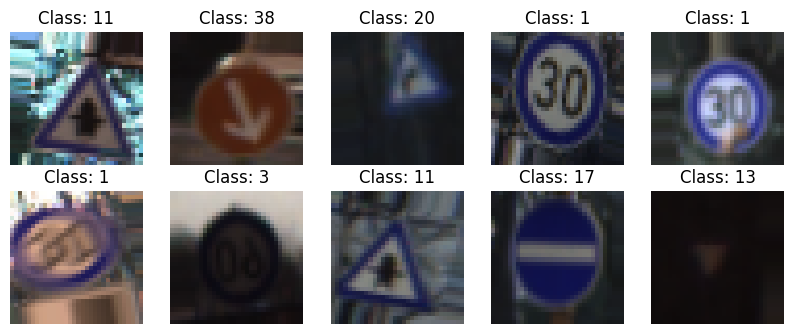

In [ ]:
import matplotlib.pyplot as plt

# Visualize some augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot some examples
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f'Class: {np.argmax(augmented_labels[i])}')
    plt.axis('off')
plt.show()

##Grayscale Conversion <br>
Since color might not always be the most important factor in recognizing traffic signs (some signs are primarily distinguished by their shape), converting images to grayscale can simplify the data and reduce model complexity.

In [ ]:
def convert_to_grayscale(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

This technique can be used for training a model that is invariant to color.

##Image Normalization <br>
Image normalization (scaling pixel values to the range [0, 1] or applying mean subtraction) helps the model converge more quickly and perform better.

In [ ]:
#X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

##Histogram Equalization <br>
To improve contrast and make features in images more distinct, you can apply histogram equalization. This technique is useful when the lighting varies significantly between images.

In [ ]:
def equalize_histogram(images):
    return np.array([cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) for img in images])

##Random Noise <br>
Adding noise to images can help the model become robust to real-world imperfections (like blurry images, sensor noise, etc.).

In [ ]:
def add_random_noise(images):
    noise_factor = 0.2
    noisy_images = images + noise_factor * np.random.randn(*images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

X_train = add_random_noise(X_train)

##Feature Scaling (Min-Max Scaling) <br>
Although normalization is more common, scaling pixel values to a different range using Min-Max Scaling can sometimes be beneficial.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_scaled = scaler.fit_transform(X_train_flat)
X_train = X_train_scaled.reshape(X_train.shape[0], 32, 32, 3)

In [ ]:
### Model Training with Augmented Data ###
from tensorflow.keras import models, layers

# Build a simple CNN model
model = models.Sequential()

# Convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Add more layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data generator
history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=5, steps_per_epoch=len(X_train) // 32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


980/980 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.2204 - loss: 2.8206 - val_accuracy: 0.6194 - val_loss: 1.0773
Epoch 2/5
  1/980 ━━━━━━━━━━━━━━━━━━━━ 1:09 71ms/step - accuracy: 0.6562 - loss: 1.3074

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


980/980 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6562 - loss: 1.3074 - val_accuracy: 0.6178 - val_loss: 1.0807
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 75s 77ms/step - accuracy: 0.6276 - loss: 1.1258 - val_accuracy: 0.8250 - val_loss: 0.5245
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6875 - loss: 0.9054 - val_accuracy: 0.8207 - val_loss: 0.5251
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 79s 79ms/step - accuracy: 0.7607 - loss: 0.7086 - val_accuracy: 0.8525 - val_loss: 0.4386


In [ ]:
# Path to test CSV file
test_csv_path = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/GT-final_test.test.csv'
# Load the test labels from the CSV file
test_data = pd.read_csv(test_csv_path, sep=";")

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc}')

# Get model predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8556 - loss: 0.4386
Test accuracy: 0.8524610996246338
246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.34      0.51        38
           1       0.82      0.91      0.86       496
           2       0.67      0.90      0.77       450
           3       0.73      0.86      0.79       280
           4       0.92      0.97      0.94       418
           5       0.52      0.23      0.32       364
           6       0.87      0.98      0.92        59
           7       0.95      0.14      0.24       278
           8       0.53      0.86      0.65       301
           9       0.98      0.95      0.97       268
          10       0.98      0.96      0.97       370
          11       0.97      0.95      0.96       236
          12       1.00      1.00      1.00       450
          13       1.00      1.00      1.00       452
          14 

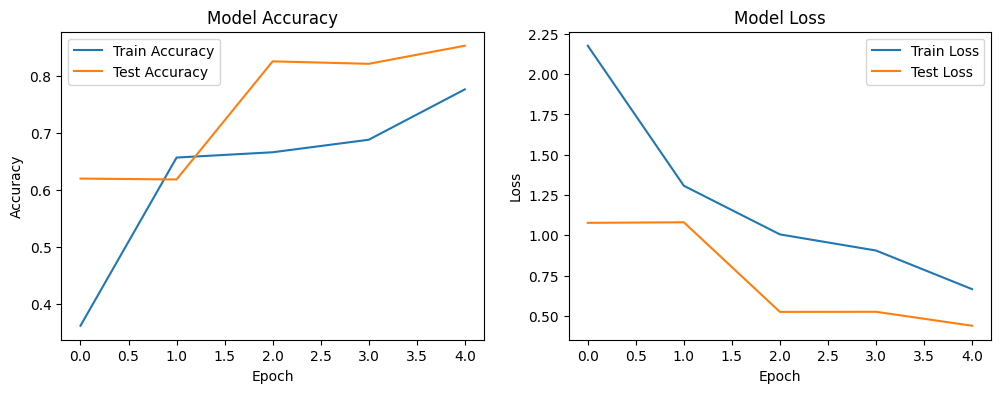

In [ ]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()

In [ ]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32')
    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

# Normalize pixel values (same as training data)
X_test = X_test / 255.0

# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)

print("Predictions saved to 'gtsrb_test_predictions.csv'")

In [ ]:
# Load test images
def load_test_data(test_dir, test_csv):
    test_images = []
    test_labels = []

    # Load the test labels from the CSV file
    test_data = pd.read_csv(test_csv, sep=";")

    for index, row in test_data.iterrows():
        img_path = os.path.join(test_dir, row['Filename'])
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        test_images.append(image)
        test_labels.append(row['ClassId'])

    test_images = np.array(test_images, dtype='float32')
    test_labels = np.array(test_labels)

    return test_images, test_labels

# Path to test CSV file
test_csv_path = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/GT-final_test.test.csv'

# Load test data
X_test, y_test = load_test_data(test_dir, test_csv_path)

# Normalize test images
X_test = X_test / 255.0

# One-hot encode the test labels
y_test = to_categorical(y_test, num_classes)

print(f'Test data shape: {X_test.shape}')

KeyError: 'ClassId'